# SIR модель #
Работа выполнена студентом группы 23КНТ2 ИМИКН ВШЭ НН ***Власовым Артёмом Дмитриевичем***

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [30]:
df = pd.read_excel('Великобритания.xlsx', sheet_name='Sheet1')
df.head()

,Страна,Дата,Заражений,Выздоровлений,Смертей,Заражений за день,Выздоровлений за день,Смертей за день,Население страны,Тестов,Тестов за день
0,Великобритания,20.07.2020,296940,1413.0,41090,586,0.0,10,63181775,8256935,121693
1,Великобритания,21.07.2020,297385,1414.0,41115,445,1.0,25,63181775,8388397,131462
2,Великобритания,22.07.2020,297948,1416.0,41132,563,2.0,17,63181775,8522679,134282
3,Великобритания,23.07.2020,298727,1425.0,41141,779,9.0,9,63181775,8663993,141314
4,Великобритания,24.07.2020,299495,1425.0,41173,768,0.0,32,63181775,8798036,134043


In [31]:
df.tail()

,Страна,Дата,Заражений,Выздоровлений,Смертей,Заражений за день,Выздоровлений за день,Смертей за день,Население страны,Тестов,Тестов за день
604,Великобритания,16.03.2022,20059641,NaN,163833,93943,NaN,153,63181775,476632060,853716
605,Великобритания,17.03.2022,20150847,NaN,163972,91206,NaN,139,63181775,477378853,746793
606,Великобритания,18.03.2022,20243940,NaN,164099,93093,NaN,127,63181775,477950504,571651
607,Великобритания,19.03.2022,20243940,NaN,164099,0,NaN,0,63181775,478578610,628106
608,Великобритания,20.03.2022,20243940,NaN,164099,0,NaN,0,63181775,0,0


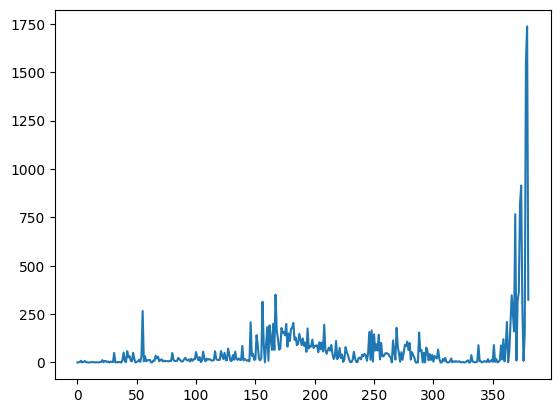

In [32]:
plt.plot(df.index, df['Выздоровлений за день'])
plt.show()

Смотрим, в какие столбцах есть пропуски

In [33]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 609 entries, 0 to 608
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Страна                 609 non-null    object 
 1   Дата                   609 non-null    object 
 2   Заражений              609 non-null    int64  
 3   Выздоровлений          381 non-null    float64
 4   Смертей                609 non-null    int64  
 5   Заражений за день      609 non-null    int64  
 6   Выздоровлений за день  381 non-null    float64
 7   Смертей за день        609 non-null    int64  
 8   Население страны       609 non-null    int64  
 9   Тестов                 609 non-null    int64  
 10  Тестов за день         609 non-null    int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 52.5+ KB
None


# Работает с пропущенными значениями c использованием линейной регрессии

Как мы видим, начиная с 381 строки в столбцах **'Выздоровлений за день'** и **'Выздоровлений'** вместо данных идут пропуски. Используем линейную регрессию, чтобы обучить на первых 300+ строках, а затем предсказать недостающие значения.

Перейдём к следующим шагам:

1. Построим модель случайного леса по непустым данным.

2. Применим её к строкам с пропущенными значениями.

3. Заполним пропуски предсказаниями модели.

In [34]:
from sklearn.ensemble import RandomForestRegressor

def fill_daily_recovered(df):
    """
    Заполнение ежедневных выздоровлений через регрессию
    """

    df['day_num'] = df.index

    known = df[df['Выздоровлений за день'].notna()]

    X = known[['day_num', 'Тестов за день']].values
    y = known['Выздоровлений за день'].values

    # Обучаем модель
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)

    all_X = df[['day_num', 'Тестов за день']].values
    predicted = model.predict(all_X)

    filled = df['Выздоровлений за день'].where(
        df['Выздоровлений за день'].notna(),
        np.round(predicted).clip(min=0)
    )
    return filled.astype(int)

Заполняем пропуски

In [35]:
df['Выздоровлений за день'] = fill_daily_recovered(df)

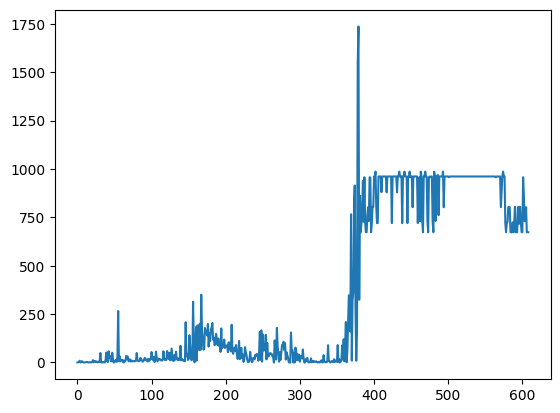

In [42]:
plt.plot(df.index, df['Выздоровлений за день'])
plt.show()

Вычисляем значения для столбца 'Выздоровлений' начиная с 381 строки, поскольку там тоже пропуски, но зная изначальное выздоровлений и все данные о выздоровлениях в день мы можем всё вычислить

In [ ]:
start_index = 381

for i in range(start_index, len(df)):
    df.loc[i, 'Выздоровлений'] = df.loc[i-1, 'Выздоровлений'] + df.loc[i, 'Выздоровлений за день']

In [ ]:
# Проверяем, нет ли пустых значений
df[df["Выздоровлений"].isnull()]

,Страна,Дата,Заражений,Выздоровлений,Смертей,Заражений за день,Выздоровлений за день,Смертей за день,Население страны,Тестов,Тестов за день,day_num


Удаляем столбец **'Страна'**, **'Тестов'**, **'Тестов за день''**, **'Смертей за день'** и **'index'** поскольку он не несёт никакой полезной информации

In [15]:
df.drop(columns=['Страна'], inplace=True)
df.drop(columns=['Тестов'], inplace=True)
df.drop(columns=['Тестов за день'], inplace=True)
df.drop(columns=['index'], inplace=True)
df.head()

,Дата,Заражений,Выздоровлений,Смертей,Заражений за день,Выздоровлений за день,Смертей за день,Население страны
0,20.07.2020,296940,1413.0,41090,586,0.0,10,63181775
1,21.07.2020,297385,1414.0,41115,445,1.0,25,63181775
2,22.07.2020,297948,1416.0,41132,563,2.0,17,63181775
3,23.07.2020,298727,1425.0,41141,779,9.0,9,63181775
4,24.07.2020,299495,1425.0,41173,768,0.0,32,63181775


### 1. Вычислить количество инфицированных I на каждый день наблюдений

In [44]:
df['I'] = df['Заражений'] - df['Выздоровлений'] - df['Смертей']
df.head()

,Страна,Дата,Заражений,Выздоровлений,Смертей,Заражений за день,Выздоровлений за день,Смертей за день,Население страны,Тестов,Тестов за день,day_num,I,gamma_est
0,Великобритания,20.07.2020,296940,1413.0,41090,586,0,10,63181775,8256935,121693,0,254437.0,NaN
1,Великобритания,21.07.2020,297385,1414.0,41115,445,1,25,63181775,8388397,131462,1,254856.0,0.000004
2,Великобритания,22.07.2020,297948,1416.0,41132,563,2,17,63181775,8522679,134282,2,255400.0,0.000008
3,Великобритания,23.07.2020,298727,1425.0,41141,779,9,9,63181775,8663993,141314,3,256161.0,0.000035
4,Великобритания,24.07.2020,299495,1425.0,41173,768,0,32,63181775,8798036,134043,4,256897.0,0.000000


### 2. Выполнить нормировку данных на 100 тыс. населения

In [45]:
population = df['Население страны'].iloc[0]

# Нормировка данных на 100k населения
df['I_norm'] = df['I'] / population * 100000
df['R'] = df['Выздоровлений'] + df['Смертей']
df['R_norm'] = df['R'] / population * 100000
df['S'] = df['Население страны'] - df['I'] - df['R']
df['S_norm'] = df['S'] / population * 100000

In [46]:
df.head()

,Страна,Дата,Заражений,Выздоровлений,Смертей,Заражений за день,Выздоровлений за день,Смертей за день,Население страны,Тестов,Тестов за день,day_num,I,gamma_est,I_norm,R,R_norm,S,S_norm
0,Великобритания,20.07.2020,296940,1413.0,41090,586,0,10,63181775,8256935,121693,0,254437.0,NaN,402.706318,42503.0,67.270981,62884835.0,99530.022700
1,Великобритания,21.07.2020,297385,1414.0,41115,445,1,25,63181775,8388397,131462,1,254856.0,0.000004,403.369484,42529.0,67.312132,62884390.0,99529.318383
2,Великобритания,22.07.2020,297948,1416.0,41132,563,2,17,63181775,8522679,134282,2,255400.0,0.000008,404.230492,42548.0,67.342204,62883827.0,99528.427304
3,Великобритания,23.07.2020,298727,1425.0,41141,779,9,9,63181775,8663993,141314,3,256161.0,0.000035,405.434953,42566.0,67.370694,62883048.0,99527.194353
4,Великобритания,24.07.2020,299495,1425.0,41173,768,0,32,63181775,8798036,134043,4,256897.0,0.000000,406.599846,42598.0,67.421341,62882280.0,99525.978813


### 3.На основе данных построить оценку параметра γ – интенсивности выздоровления

In [53]:
df['gamma'] = df['Выздоровлений за день'] / df['I'].shift(1)
gamma = df['gamma'].replace([np.inf, -np.inf], np.nan).mean()
print(f"\nОценка параметра γ: {gamma:.4f}")


Оценка параметра γ: 0.0001


### 4. С помощью метода наименьших квадратов построить оценку параметра SIR-модели β (интенсивность заражения) в предположении, что изначально все население является восприимчивым к заболеванию.

In [55]:
df.head()

,Страна,Дата,Заражений,Выздоровлений,Смертей,Заражений за день,Выздоровлений за день,Смертей за день,Население страны,Тестов,Тестов за день,day_num,I,gamma_est,I_norm,R,R_norm,S,S_norm,gamma
0,Великобритания,20.07.2020,296940,1413.0,41090,586,0,10,63181775,8256935,121693,0,254437.0,NaN,402.706318,42503.0,67.270981,62884835.0,99530.022700,NaN
1,Великобритания,21.07.2020,297385,1414.0,41115,445,1,25,63181775,8388397,131462,1,254856.0,0.000004,403.369484,42529.0,67.312132,62884390.0,99529.318383,0.000004
2,Великобритания,22.07.2020,297948,1416.0,41132,563,2,17,63181775,8522679,134282,2,255400.0,0.000008,404.230492,42548.0,67.342204,62883827.0,99528.427304,0.000008
3,Великобритания,23.07.2020,298727,1425.0,41141,779,9,9,63181775,8663993,141314,3,256161.0,0.000035,405.434953,42566.0,67.370694,62883048.0,99527.194353,0.000035
4,Великобритания,24.07.2020,299495,1425.0,41173,768,0,32,63181775,8798036,134043,4,256897.0,0.000000,406.599846,42598.0,67.421341,62882280.0,99525.978813,0.000000


In [56]:
# Функция для минимизации (МНК)
def beta_loss(beta, S, I, Delta_I, gamma, N):
    predicted_Delta_I = beta * (S * I / N) - gamma * I
    return np.sum((predicted_Delta_I - Delta_I) ** 2)

In [ ]:
from scipy.optimize import minimize

# Вычисление S и R
N = df['Население страны'].iloc[0]
I = df['I'].values

# Вычисление ΔI
df['Delta_I'] = df['Заражений за день'] - df['Выздоровлений за день'] - df['Смертей за день']

# Разбиение на интервалы (я беру по 7 дней)
interval_size = 7
beta_estimates = []

for start in range(0, len(df), interval_size):
    end = min(start + interval_size, len(df))
    interval_df = df.iloc[start:end]
    
    # Начальное значение beta
    beta0 = 0.1
    
    # Минимизация
    result = minimize(
        beta_loss,
        beta0,
        args=(
            interval_df['S'].values,
            interval_df['I'].values,
            interval_df['Delta_I'].values,
            gamma,
            N
        ),
        method='Nelder-Mead'
    )
    
    beta_estimates.append({
        'interval': f'{interval_df["Дата"].iloc[0]} - {interval_df["Дата"].iloc[-1]}',
        'beta': result.x[0]
    })

# Вывод результатов
for estimate in beta_estimates:
    print(f"Интервал: {estimate['interval']}, β = {estimate['beta']:.6f}")

Интервал: 20.07.2020 - 26.07.2020, β = 0.002587
Интервал: 27.07.2020 - 02.08.2020, β = 0.002899
Интервал: 03.08.2020 - 09.08.2020, β = 0.003376
Интервал: 10.08.2020 - 16.08.2020, β = 0.004061
Интервал: 17.08.2020 - 23.08.2020, β = 0.003717
Интервал: 24.08.2020 - 30.08.2020, β = 0.004461
Интервал: 31.08.2020 - 06.09.2020, β = 0.006099
Интервал: 07.09.2020 - 13.09.2020, β = 0.009577
Интервал: 14.09.2020 - 20.09.2020, β = 0.010870
Интервал: 21.09.2020 - 27.09.2020, β = 0.015598
Интервал: 28.09.2020 - 04.10.2020, β = 0.023702
Интервал: 05.10.2020 - 11.10.2020, β = 0.027888
Интервал: 12.10.2020 - 18.10.2020, β = 0.027105
Интервал: 19.10.2020 - 25.10.2020, β = 0.028388
Интервал: 26.10.2020 - 01.11.2020, β = 0.025134
Интервал: 02.11.2020 - 08.11.2020, β = 0.021001
Интервал: 09.11.2020 - 15.11.2020, β = 0.020631
Интервал: 16.11.2020 - 22.11.2020, β = 0.014626
Интервал: 23.11.2020 - 29.11.2020, β = 0.009910
Интервал: 30.11.2020 - 06.12.2020, β = 0.009432
Интервал: 07.12.2020 - 13.12.2020, β = 0

In [63]:
beta = estimate['beta'].mean()
print(f"\nОценка параметра β: {beta:.4f}")


Оценка параметра β: 0.0061


# OR

In [ ]:
# Подготовка к оценке β
df['dI'] = df['Заражений за день'] - df['Выздоровлений за день'] - df['Смертей за день']
df['lhs'] = df['dI'] + gamma * df['I']
df['rhs'] = df['S'] * df['I'] / df['Население страны']

import statsmodels.api as sm
X = sm.add_constant(df['rhs'])
model = sm.OLS(df['lhs'], X).fit()
beta = model.params[1]
print(f"\nОценка параметра β: {beta:.4f}")

# 5. Построить график зависимости среднего количества инфицированных от времени. Для сравнения на той же диаграмме построить график для реальных (нормированных) данных

In [ ]:
from scipy.integrate import odeint

N = df['Население страны'].iloc[0]
I0 = df['I'].iloc[0]
R0 = df['R'].iloc[0]
S0 = N - I0 - R0
y0 = [S0, I0, R0]

t = np.arange(len(df))  # временная ось в днях

# SIR уравнения
def SIR(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

# Решение ОДУ
ret = odeint(SIR, y0, t, args=(N, beta, gamma))
S, I, R = ret.T
I_model_norm = I / N * 100000

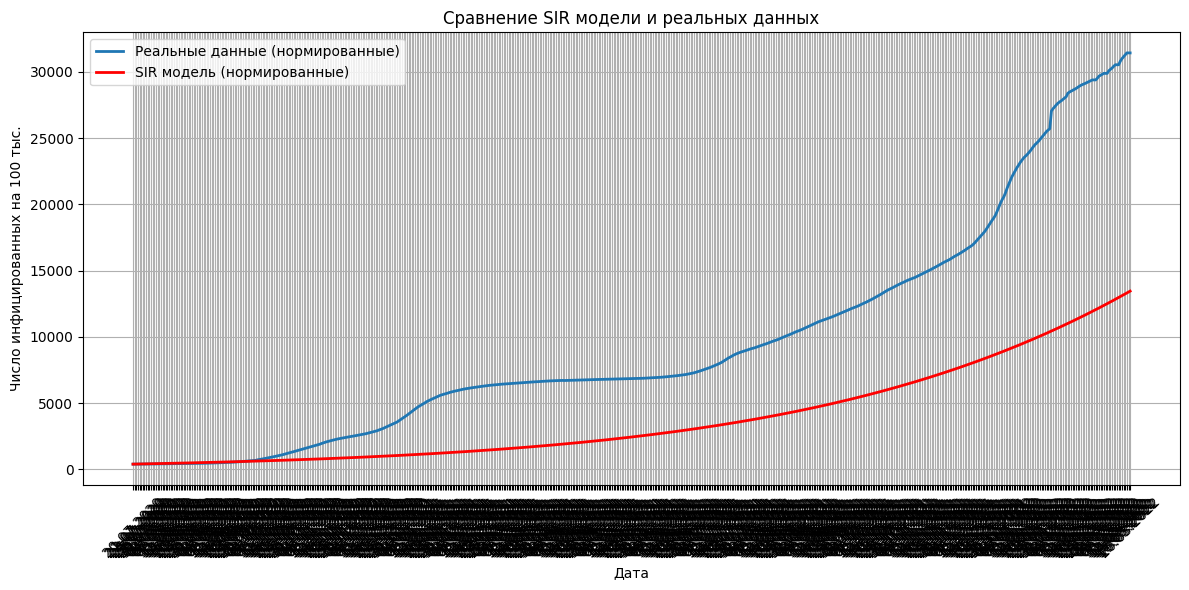

In [67]:
plt.figure(figsize=(12, 6))
plt.plot(df['Дата'], df['I_norm'], label='Реальные данные (нормированные)', lw=2)
plt.plot(df['Дата'], I_model_norm, label='SIR модель (нормированные)', lw=2, color = 'red', linestyle='-')
plt.xlabel('Дата')
plt.ylabel('Число инфицированных на 100 тыс.')
plt.title('Сравнение SIR модели и реальных данных')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
